In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.integrate import solve_ivp, ode

In [42]:
N     = 25    # number of levels for the charger
NB    = 25    # number of levels for the battery 
w0    = 1
g     = 0.2   # coupling strength
gam   = 0.05
F     = 0.1
NT    = 0
delta = 0
nmax  = 90
tm    = 4
u     = 0.05
tlist = np.linspace(0, tm*np.pi/g, nmax+1)  # time in ps

In [121]:
vac   = tensor(basis(N, 0), basis(NB, 0))  # the vacuum state for the system
a     = tensor(destroy(N), qeye(NB))  # the annihilation operator for charger
b     = tensor(qeye(N), destroy(NB))  # the annihilation operator for battery

# intial state
psi0  = vac

# number operators
s1    = a.dag()*a
s2    = b.dag()*b

In [122]:
# Hamiltonian of system
H     = delta*s1 + delta*s2 + g*(a*b.dag()+a.dag()*b)+F*(a.dag()+a)+u*b.dag()*b.dag()*b*b

In [123]:
c_ops = [np.sqrt(gam*(NT+1))*a, np.sqrt(gam*NT)*a.dag()]

In [124]:
# the density operator
options        = Options()
options.nsteps = 6000
outputdens     = mesolve(H, psi0, tlist, c_ops, e_ops=[],options=options)  # Lindbladian ME solution

In [125]:
qsave(outputdens, 'density_matrix_u005gam005')#saving density matrix

In [109]:
bb = destroy(NB)  # the annihilation operator for battery
H2 = bb.dag()*bb + u*bb.dag()*bb.dag()*bb*bb

def passive(t):#passive energy
    i = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = outputdens.states[x]
        sortedeigv = np.sort(np.linalg.eigvals(density.ptrace(1)))[::-1]
        sortedeigv = np.where(sortedeigv<0,0,sortedeigv)
        # the eigenenergy
        sorten = np.sort(H2.eigenstates()[0])
        # useless energy
        EF = np.dot(sorten, sortedeigv)
        evals_mat[i] = EF
        i += 1
    return evals_mat

def eb(t):#battery energy
    i = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = outputdens.states[x]
        y = H2*density.ptrace(1)
        evals_mat[i] = y.tr()
        i += 1
    return evals_mat

In [110]:
Efin = passive(tlist)
EBA  = eb(tlist)
ergotropy = EBA-Efin

/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/1371979668.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  evals_mat[i] = EF


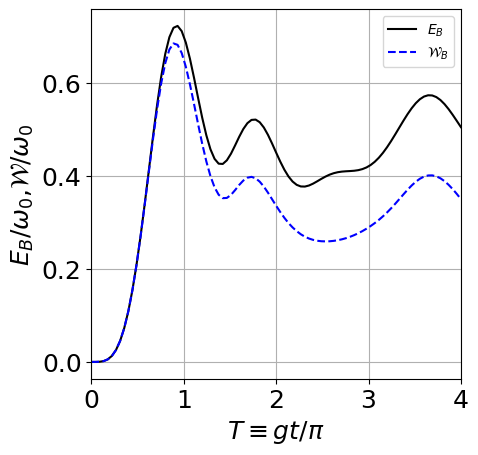

In [111]:
fig  = plt.figure()
axes = fig.add_subplot(111)
axes.plot(tlist/np.pi*g, EBA, 'k-', label='$E_B$')
axes.plot(tlist/np.pi*g, ergotropy, 'b--', label='$\mathcal{W}_B$')
axes.legend(loc=0)
plt.xlabel('$t$', size=18)
plt.ylabel('Occupation', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, tm])
#plt.ylim([0, 8])
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$,$\mathcal{W}/\omega_0$', size=18)
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.show()

In [4]:
#semiclassical mean field
def rhooneb(t,y,N,F,g,gam,dlt,u):
    fa,fb= y
    fad  = -1j*(g*fb+F)-gam/2*fa-1j*dlt*fa
    fbd  = -1j*g*fa-1j*dlt*fb -1j * 2 * u * np.conjugate(fb) * fb *fb
    dydt = [fad,fbd]
    return (dydt)
y0,t0 = [0,0],0

def ergb1(tt,N,F,g,gam,dlt,u):
    slc = ode(lambda t,y: rhooneb(t,y,N,F,g,gam,dlt,u),jac=None).set_integrator('zvode', nsteps=2000000000)
    slc.set_initial_value(y0, t0)
    xx     = slc.integrate(slc.t+(tt)/g)
    zz     = xx[1]*np.conjugate(xx[1]) + u * (xx[1]*np.conjugate(xx[1]))**2
    return  np.array([zz])

In [38]:
nd = 100
EBBb1= np.zeros(nd+1,dtype=np.complex_)
EBBb2= np.zeros(nd+1,dtype=np.complex_)
EBBb3= np.zeros(nd+1,dtype=np.complex_)
td = np.zeros(nd+1)
for i in range (nd+1):
    td[i]  = (6*np.pi)/nd*i
    EBBb1[i] = ergb1(td[i],0,0.5,g,1,0.2,0.1)[0]
    EBBb2[i] = ergb1(td[i],0,0.5,g,1,0.2,0.02)[0]
    EBBb3[i] = ergb1(td[i],0,0.5,g,1,0.2,0)[0]

In [6]:
#loading all the density matrix
densqbt  = qload('density_matrix_qbt')
dens0005 = qload('density_matrix_u0005')
dens002  = qload('density_matrix_u002')
dens005  = qload('density_matrix_u005')
dens007  = qload('density_matrix_u007')
dens01   = qload('density_matrix_u01')
dens015  = qload('density_matrix_u015')
densosc  = qload('density_matrix_osc')

dens007g1 = qload('density_matrix_u007gam1') #data 35
dens002g1 = qload('density_matrix_u002gam1')
dens01g1  = qload('density_matrix_u01gam1')
densoscg1 = qload('density_matrix_oscgam1')
densqbtg1 = qload('density_matrix_qbtgam1')

dens005g005 = qload('density_matrix_u005gam005')
dens01g005  = qload('density_matrix_u01gam005')
densoscg005 = qload('density_matrix_oscgam005')
densqbtg005 = qload('density_matrix_qbtgam005')

In [7]:
def passiven(t,den,nn,uu):#passive energy, den is density matrix that is saved
    bb = destroy(nn)  # the annihilation operator for battery
    H2 = bb.dag()*bb + uu*bb.dag()*bb.dag()*bb*bb
    i = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = den.states[x]
        sortedeigv = np.sort(np.linalg.eigvals(density.ptrace(1)))[::-1]
        sortedeigv = np.where(sortedeigv<0,0,sortedeigv)
        # the eigenenergy
        sorten = np.sort(H2.eigenstates()[0])
        # useless energy
        EF = np.dot(sorten, np.abs(sortedeigv))
        evals_mat[i] = EF
        i += 1
    return evals_mat

def ebn(t,den,nn,uu):##battery energy, den is density matrix that is saved
    bb = destroy(nn)  # the annihilation operator for battery
    H2 = bb.dag()*bb + uu*bb.dag()*bb.dag()*bb*bb
    i  = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = den.states[x]
        y = H2*density.ptrace(1)
        evals_mat[i] = y.tr()
        i += 1
    return evals_mat

def ebnm(t,den,nn,uu):#pmax battery energy, den is density matrix that is saved
    bb = destroy(nn)  # the annihilation operator for battery
    H2 = bb.dag()*bb + uu*bb.dag()*bb.dag()*bb*bb
    i  = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = den.states[x]
        y = H2*density.ptrace(1)
        evals_mat[i] = y.tr()
        tmax = np.argmax(evals_mat) * t[nmax] / nmax
        i += 1
    return np.array([np.max(evals_mat),tmax*g/np.pi])

def ebnmf(t,den,nn,uu):#mean field energy
    bb = destroy(nn)
    i  = 0
    evals_mat = np.zeros(len(t))
    for tt in t:
        x = round(tt / t[nmax] * nmax)
        density = den.states[x]
        y = bb*density.ptrace(1)
        z = bb.dag() * bb *density.ptrace(1)
        evals_mat[i] = (y.tr()) * np.conjugate(y.tr())+uu*(y.tr()) * np.conjugate(y.tr())*(y.tr()) * np.conjugate(y.tr())
        i += 1
    return evals_mat

In [10]:
Efin0005 = passiven(tlist,dens0005,NB,0.005)
EBA0005  = ebn(tlist,dens0005,NB,0.005)
ergotropy0005 = -(Efin0005-EBA0005)
EBX0005  = ebnm(tlist,dens0005,NB,0.005)[0]
TX0005   = ebnm(tlist,dens0005,NB,0.005)[1]

Efin002  = passiven(tlist,dens002,NB,0.02)
EBA002   = ebn(tlist,dens002,NB,0.02)
ergotropy002 = -(Efin002-EBA002)
EBX002   = ebnm(tlist,dens002,NB,0.02)[0]
TX002    = ebnm(tlist,dens002,NB,0.02)[1]

Efin005  = passiven(tlist,dens005,NB,0.05)
EBA005   = ebn(tlist,dens005,NB,0.05)
ergotropy005 = -(Efin005-EBA005)
EBX005   = ebnm(tlist,dens005,NB,0.05)[0]
TX005    = ebnm(tlist,dens005,NB,0.05)[1]

Efin007  = passiven(tlist,dens007,NB,0.07)
EBA007   = ebn(tlist,dens007,NB,0.07)
ergotropy007 = -(Efin007-EBA007)
EBX007   = ebnm(tlist,dens007,NB,0.07)[0]
TX007    = ebnm(tlist,dens007,NB,0.07)[1]

Efin01   = passiven(tlist,dens01,NB,0.1)
EBA01    = ebn(tlist,dens01,NB,0.1)
ergotropy01 = -(Efin01-EBA01)
EBX01    = ebnm(tlist,dens01,NB,0.1)[0]
TX01     = ebnm(tlist,dens01,NB,0.1)[1]

Efin015  = passiven(tlist,dens015,NB,0.15)
EBA015   = ebn(tlist,dens015,NB,0.15)
ergotropy015 = -(Efin015-EBA015)
EBX015   = ebnm(tlist,dens015,NB,0.15)[0]
TX015    = ebnm(tlist,dens015,NB,0.15)[1]

Efinqbt  = passiven(tlist,densqbt,2,0)
EBAqbt   = ebn(tlist,densqbt,2,0)
ergotropyqbt = -(Efinqbt-EBAqbt)
EBXqbt   = ebnm(tlist,densqbt,2,0)[0]
TXqbt    = ebnm(tlist,densqbt,2,0)[1]

Efinosc  = passiven(tlist,densosc,NB,0)
EBAosc   = ebn(tlist,densosc,NB,0)
ergotropyosc = -(Efinosc-EBAosc)
EBXosc   = ebnm(tlist,densosc,NB,0)[0]
TXosc    = ebnm(tlist,densosc,NB,0)[1]

In [43]:
Efinoscg1 = passiven(tlist,densoscg1,25,0)
EBAoscg1  = ebn(tlist,densoscg1,25,0)
ergotropyoscg1 = -(Efinoscg1-EBAoscg1)
EBXoscg1  = ebnm(tlist,densoscg1,25,0)[0]
TXoscg1   = ebnm(tlist,densoscg1,25,0)[1]

Efin002g1 = passiven(tlist,dens002g1,NB,0.02)
EBA002g1  = ebn(tlist,dens002g1,NB,0.02)
ergotropy002g1 = -(Efin015-EBA015)
EBX002g1  = ebnm(tlist,dens002g1,NB,0.02)[0]
TX0002g1  = ebnm(tlist,dens002g1,NB,0.02)[1]

Efin01g1  = passiven(tlist,dens01g1,25,0.1)
EBA01g1   = ebn(tlist,dens01g1,25,0.1)
ergotropy01g1 = -(Efin01g1-EBA01g1)
EBX01g1   = ebnm(tlist,dens01g1,25,0.1)[0]
TX001g1   = ebnm(tlist,dens01g1,25,0.1)[1]

Efinqbtg1 = passiven(tlist,densqbtg1,2,0)
EBAqbtg1  = ebn(tlist,densqbtg1,2,0)
ergotropyqbtg1 = -(Efinqbt-EBAqbt)
EBXqbtg1  = ebnm(tlist,densqbtg1,2,0)[0]
TXqbtg1   = ebnm(tlist,densqbtg1,2,0)[1]

In [127]:
Efinoscg005 = passiven(tlist,densoscg005,35,0)
EBAoscg005  = ebn(tlist,densoscg005,35,0)

Efin005g005 = passiven(tlist,dens005g005,35,0.05)
EBA005g005  = ebn(tlist,dens005g005,35,0.05)

Efin01g005  = passiven(tlist,dens01g005,35,0.1)
EBA01g005   = ebn(tlist,dens01g005,35,0.1)

Efinqbtg005 = passiven(tlist,densqbtg005,2,0)
EBAqbtg005  = ebn(tlist,densqbtg005,2,0)

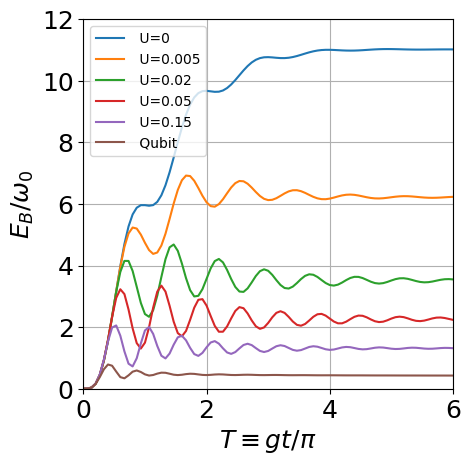

In [12]:
fig  = plt.figure()
axes = fig.add_subplot(111)

axes.plot(tlist/np.pi*g, EBAosc, label =' U=0')
axes.plot(tlist/np.pi*g, EBA0005,label =' U=0.005')
#axes.plot(td/np.pi, EBBb3,'k--')
axes.plot(tlist/np.pi*g, EBA002,label =' U=0.02')
axes.plot(tlist/np.pi*g, EBA005,label =' U=0.05')
#axes.plot(td/np.pi, EBBb2,'k--')
#axes.plot(tlist/np.pi*g, EBA007,label =' U=0.07')
#axes.plot(tlist/np.pi*g, EBA01,label =' U=0.1')
axes.plot(tlist/np.pi*g, EBA015,label =' U=0.15')
# axes.plot(td/np.pi, EBBb1,'k--')
axes.plot(tlist/np.pi*g, EBAqbt,label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 6])
plt.ylim([0, 12])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom.pdf')
plt.show()

In [35]:
import csv

file = open("fig2a.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBAosc[w], EBA0005[w], EBA002[w],EBA005[w],EBA015[w],EBAqbt[w]])

file.close()

/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/2202625545.py:5: RuntimeWarning: invalid value encountered in divide
  axes.plot(tlist/np.pi*g, EBA0005/(tlist*g),label =' U=0.005')
/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/2202625545.py:6: RuntimeWarning: invalid value encountered in divide
  axes.plot(tlist/np.pi*g, EBA002/(tlist*g),label =' U=0.02')
/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/2202625545.py:9: RuntimeWarning: invalid value encountered in divide
  axes.plot(tlist/np.pi*g, EBA01/(tlist*g),label =' U=0.1')
/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/2202625545.py:11: RuntimeWarning: invalid value encountered in divide
  axes.plot(tlist/np.pi*g, EBAqbt/(tlist*g),label =' Qubit')


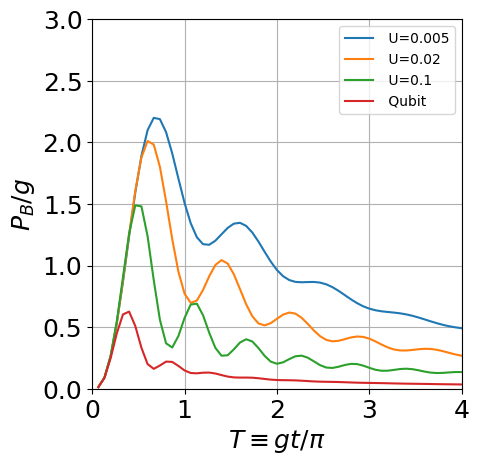

In [44]:
fig = plt.figure()
axes = fig.add_subplot(111)

# axes.plot(tlist/np.pi*g, EBAosc/(tlist*g), label =' U=0')
axes.plot(tlist/np.pi*g, EBA0005/(tlist*g),label =' U=0.005')
axes.plot(tlist/np.pi*g, EBA002/(tlist*g),label =' U=0.02')
# axes.plot(tlist/np.pi*g, EBA005,label =' U=0.05')
# axes.plot(tlist/np.pi*g, EBA007,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01/(tlist*g),label =' U=0.1')
# axes.plot(tlist/np.pi*g, EBA015,label =' U=0.15')
axes.plot(tlist/np.pi*g, EBAqbt/(tlist*g),label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$P_B/g$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 3])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('power.pdf')
plt.show()

In [45]:
import csv

file   = open("fig4b.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBA0005[w]/(tlist[w]*g), EBA002[w]/(tlist[w]*g),EBA01[w]/(tlist[w]*g),EBAqbt[w]/(tlist[w]*g)])

file.close()

/var/folders/ny/ryghb4mn1sldsy9sk43x8tc40000gn/T/ipykernel_9620/172996530.py:7: RuntimeWarning: invalid value encountered in double_scalars
  writer.writerow([tlist[w]/np.pi*g, EBA0005[w]/(tlist[w]*g), EBA002[w]/(tlist[w]*g),EBA01[w]/(tlist[w]*g),EBAqbt[w]/(tlist[w]*g)])


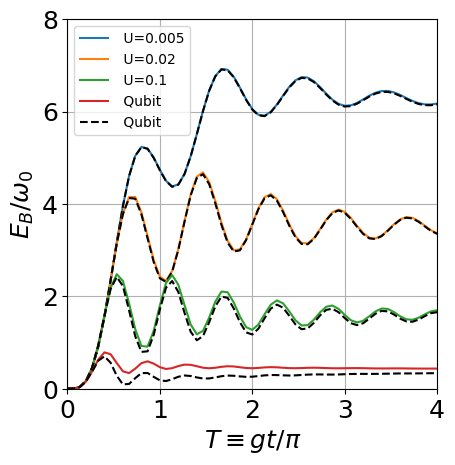

In [14]:
fig  = plt.figure()
axes = fig.add_subplot(111)

# axes.plot(tlist/np.pi*g, EBAosc, label =' U=0')
axes.plot(tlist/np.pi*g, EBA0005,label =' U=0.005')
axes.plot(tlist/np.pi*g, ergotropy0005,'k--')
axes.plot(tlist/np.pi*g, EBA002,label =' U=0.02')
# axes.plot(tlist/np.pi*g, EBA005,label =' U=0.05')
axes.plot(tlist/np.pi*g, ergotropy002,'k--')
# axes.plot(tlist/np.pi*g, EBA007,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01,label =' U=0.1')
# axes.plot(tlist/np.pi*g, EBA015,label =' U=0.15')
axes.plot(tlist/np.pi*g, ergotropy01,'k--')
axes.plot(tlist/np.pi*g, EBAqbt,label =' Qubit')
axes.plot(tlist/np.pi*g, ergotropyqbt,'k--',label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 8])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('ergo1.pdf')
plt.show()

In [43]:
import csv

file = open("fig4a-ergo.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, ergotropy0005[w], ergotropy002[w],ergotropy01[w],ergotropyqbt[w]])

file.close()

In [ ]:
file = open("fig4a.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBA0005[w], EBA002[w],EBA01[w],EBAqbt[w]])

file.close()

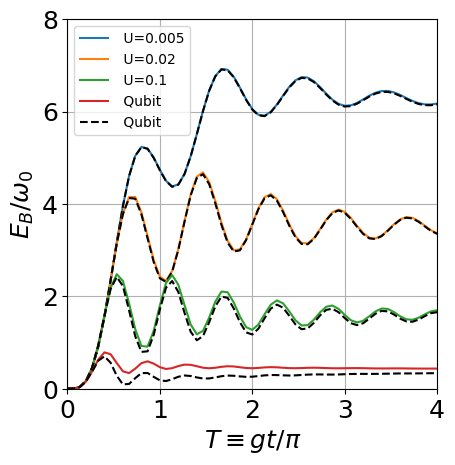

In [46]:
fig  = plt.figure()
axes = fig.add_subplot(111)

# axes.plot(tlist/np.pi*g, EBAosc, label =' U=0')
axes.plot(tlist/np.pi*g, EBA0005,label =' U=0.005')
axes.plot(tlist/np.pi*g, ergotropy0005,'k--')
axes.plot(tlist/np.pi*g, EBA002,label =' U=0.02')
# axes.plot(tlist/np.pi*g, EBA005,label =' U=0.05')
axes.plot(tlist/np.pi*g, ergotropy002,'k--')
# axes.plot(tlist/np.pi*g, EBA007,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01,label =' U=0.1')
# axes.plot(tlist/np.pi*g, EBA015,label =' U=0.15')
axes.plot(tlist/np.pi*g, ergotropy01,'k--')
axes.plot(tlist/np.pi*g, EBAqbt,label =' Qubit')
axes.plot(tlist/np.pi*g, ergotropyqbt,'k--',label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 8])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('ergo1.pdf')
plt.show()

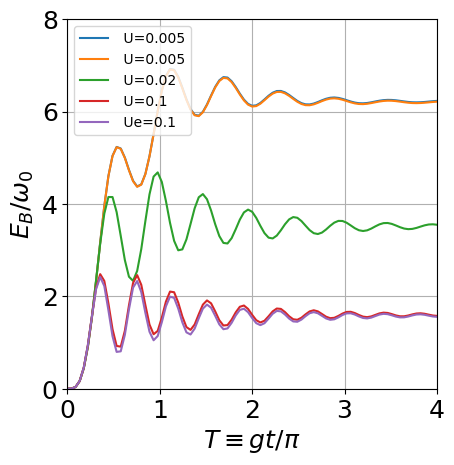

In [263]:
fig  = plt.figure()
axes = fig.add_subplot(111)

# axes.plot(tlist/np.pi*g, EBAosc, label =' U=0')
axes.plot(tlist/np.pi*g, EBA0005,label =' U=0.005')
axes.plot(tlist/np.pi*g, ergotropy0005,label =' U=0.005')
axes.plot(tlist/np.pi*g, EBA002,label =' U=0.02')
# axes.plot(tlist/np.pi*g, EBA005,label =' U=0.05')
# axes.plot(tlist/np.pi*g, EBA007,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01,label =' U=0.1')
axes.plot(tlist/np.pi*g, ergotropy01,label =' Ue=0.1')
# axes.plot(tlist/np.pi*g, EBA015,label =' U=0.15')
# axes.plot(tlist/np.pi*g, EBAqbt,label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 8])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom.pdf')
plt.show()

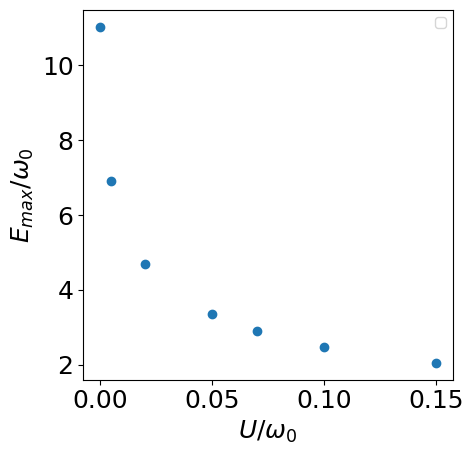

In [20]:
fig  = plt.figure()
axes = fig.add_subplot(111)

x = np.array([0,0.005,0.02,0.05,0.07,0.1,0.15])
y = np.array([EBXosc, EBX0005, EBX002, EBX005, EBX007,EBX01, EBX015])
axes.legend(loc=0)
plt.xlabel('$U/\omega_0$', size=18)
plt.ylabel('$E_{max}/\omega_0$', size=18)
plt.tick_params(labelsize=18)
#plt.xlim([0, 6])
#plt.ylim([0, 12.5])
# axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')

plt.scatter(x,y)

axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('Emax.pdf')
plt.show()

In [39]:
import csv

file = open("fig2b.txt", "w")
writer = csv.writer(file)
U = np.array([0,0.005,0.02,0.05,0.07,0.1,0.15])
EM = np.array([EBXosc, EBX0005, EBX002, EBX005, EBX007,EBX01, EBX015])
for w in range(7):
  writer.writerow([U[w], EM[w]])

file.close()

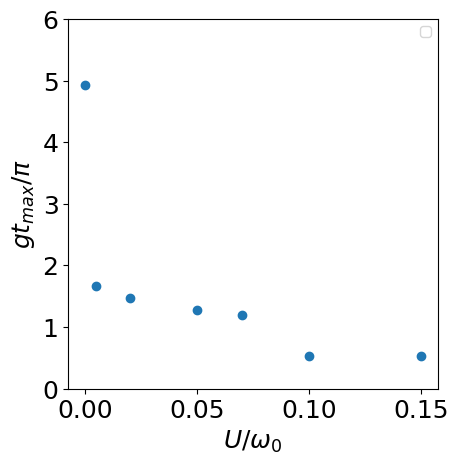

In [21]:
fig  = plt.figure()
axes = fig.add_subplot(111)

x = np.array([0,0.005,0.02,0.05,0.07,0.1,0.15])
y = np.array([TXosc, TX0005, TX002, TX005, TX007,TX01, TX015])
axes.legend(loc=0)
plt.xlabel('$U/\omega_0$', size=18)
plt.ylabel('$gt_{max}/\pi$', size=18)
plt.tick_params(labelsize=18)
#plt.xlim([0, 6])
plt.ylim([0, 6])

plt.scatter(x,y)
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('Tmax.pdf')
plt.show()

In [40]:
import csv

file = open("fig2c.txt", "w")
writer = csv.writer(file)
U = np.array([0,0.005,0.02,0.05,0.07,0.1,0.15])
TM = np.array([TXosc, TX0005, TX002, TX005, TX007,TX01, TX015])
for w in range(7):
  writer.writerow([U[w], TM[w]])

file.close()

/Users/muhamadshoufieukhtary/miniforge3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


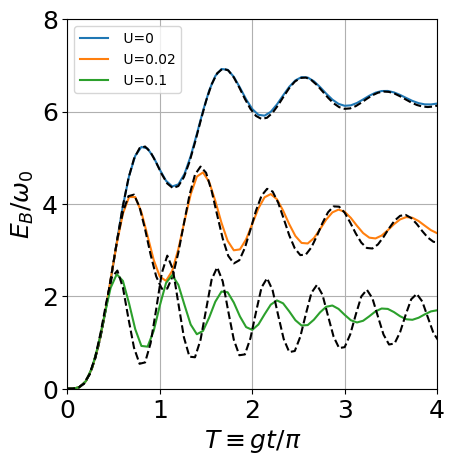

In [35]:
fig  = plt.figure()
axes = fig.add_subplot(111)

axes.plot(tlist/np.pi*g, EBA0005, label =' U=0')
axes.plot(td/np.pi, EBBb3,'k--')
axes.plot(tlist/np.pi*g, EBA002,label =' U=0.02')
axes.plot(td/np.pi, EBBb2,'k--')
# axes.plot(tlist/np.pi*g, EBA007g1,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01,label =' U=0.1')
axes.plot(td/np.pi, EBBb1,'k--')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 8])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom2.pdf')
plt.show()

In [17]:
import csv

file = open("fig3a-eb.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBA0005[w], EBA002[w],EBA01[w]])

file.close()

In [37]:
import csv

file = open("fig3a-semi.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([td[w]/np.pi, EBBb3[w], EBBb2[w],EBBb1[w]])

file.close()

/Users/muhamadshoufieukhtary/miniforge3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


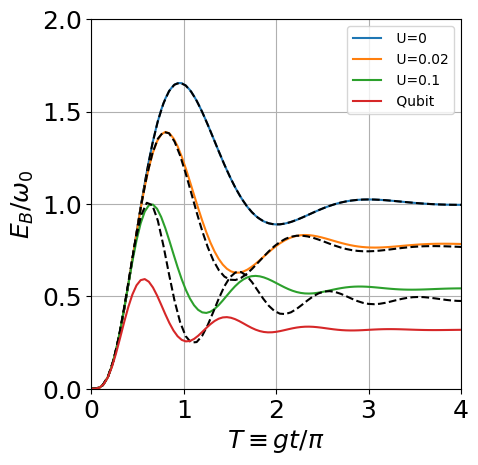

In [44]:
fig  = plt.figure()
axes = fig.add_subplot(111)

axes.plot(tlist/np.pi*g, EBAoscg1, label =' U=0')
axes.plot(td/np.pi, EBBb3,'k--')
axes.plot(tlist/np.pi*g, EBA002g1,label =' U=0.02')
axes.plot(td/np.pi, EBBb2,'k--')
# axes.plot(tlist/np.pi*g, EBA007g1,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01g1,label =' U=0.1')
axes.plot(td/np.pi, EBBb1,'k--')
axes.plot(tlist/np.pi*g, EBAqbtg1,label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 2])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom2.pdf')
plt.show()

In [74]:
import csv

file = open("fig3b-eb.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBAoscg1[w], EBA002g1[w],EBA01g1[w],EBAqbtg1[w]])

file.close()

In [45]:
import csv

file = open("fig3b-semi.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([td[w]/np.pi, EBBb3[w], EBBb2[w],EBBb1[w]])

file.close()

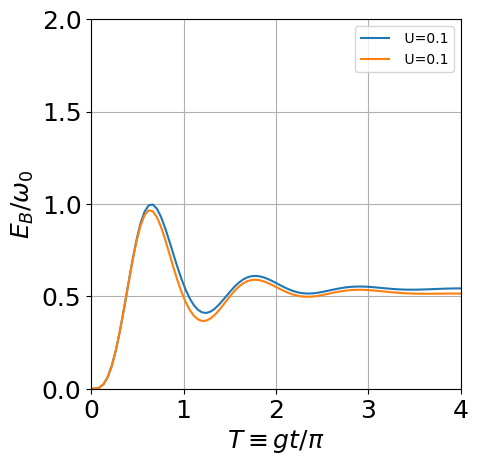

In [258]:
fig  = plt.figure()
axes = fig.add_subplot(111)

# axes.plot(tlist/np.pi*g, EBA007g1,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01g1,label =' U=0.1')
axes.plot(tlist/np.pi*g, ergotropy01g1,label =' U=0.1')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 2])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom2.pdf')
plt.show()

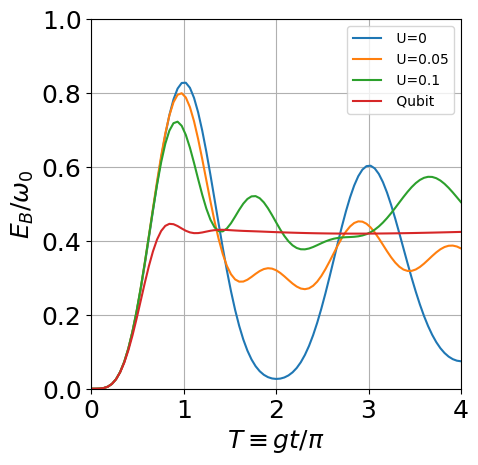

In [128]:
fig  = plt.figure()
axes = fig.add_subplot(111)

axes.plot(tlist/np.pi*g, EBAoscg005, label =' U=0')
# axes.plot(td/np.pi, EBBb3,'k--')
axes.plot(tlist/np.pi*g, EBA005g005,label =' U=0.05')
# axes.plot(td/np.pi, EBBb2,'k--')
# axes.plot(tlist/np.pi*g, EBA007g1,label =' U=0.07')
axes.plot(tlist/np.pi*g, EBA01g005,label =' U=0.1')
# axes.plot(td/np.pi, EBBb1,'k--')
axes.plot(tlist/np.pi*g, EBAqbtg005,label =' Qubit')
axes.legend(loc=0)
plt.xlabel('$T\equiv g t/\pi$', size=18)
plt.ylabel('$E_B/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
plt.xlim([0, 4])
plt.ylim([0, 1])
axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
plt.savefig('EBcom3.pdf')
plt.show()

In [129]:
import csv

file = open("fig3c.txt", "w")
writer = csv.writer(file)

for w in range(nmax+1):
  writer.writerow([tlist[w]/np.pi*g, EBAoscg005[w], EBA005g005[w],EBA01g005[w],EBAqbtg005[w]])

file.close()

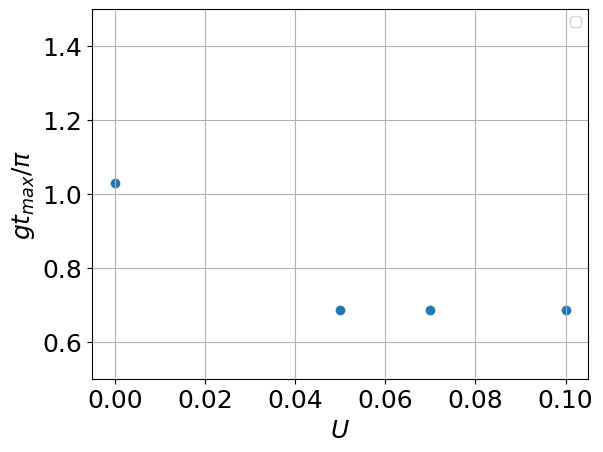

In [124]:
fig = plt.figure()
axes = fig.add_subplot(111)

x = np.array([0,0.05,0.07,0.1])
y = np.array([TXoscg1,  TX0005g1, TX0007g1,TX001g1])
axes.legend(loc=0)
plt.xlabel('$U$', size=18)
plt.ylabel('$gt_{max}/\pi$', size=18)
plt.tick_params(labelsize=18)
plt.grid()
#plt.xlim([0, 6])
plt.ylim([0.5, 1.5])
# axes.set_aspect(1.0/axes.get_data_ratio(), adjustable='box')
# plt.savefig('EBcom.pdf')
plt.scatter(x,y)
plt.show()

In [109]:
def compute(ulist):
    idx = 0
    evals_mat = np.zeros((len(ulist),N))
    for uu in ulist:
        bb = destroy(N)
        # evaluate the Hamiltonian
        H = bb.dag()*bb + uu*bb.dag()*bb.dag()*bb*bb

        # find the energy eigenvalues of the composite system
        evals, ekets = H.eigenstates()

        evals_mat[idx,:] = np.real(evals)

        idx += 1

    return evals_mat

ulist = np.linspace(0, 0.5, 50)

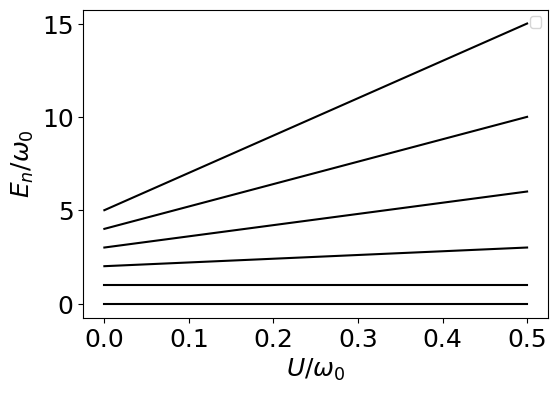

In [111]:
evals_mat = compute(ulist)

fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(111)
for n in [0,1,2,3,4,5]:
    axes.plot(ulist, (evals_mat[:,n]), 'k')
axes.legend(loc=0)
plt.xlabel('$U/\omega_0$', size=18)
plt.ylabel('$E_n/\omega_0$', size=18)
plt.tick_params(labelsize=18)
plt.savefig('En.pdf')

In [210]:
np.sort(((dens01g1.states[7]).ptrace(1)).eigenstates()[0])

array([-5.16963001e-05, -1.02078203e-07, -3.55649785e-10, -3.95836016e-13,
       -5.70674586e-16, -3.49006972e-18, -3.96285938e-19, -6.34871778e-22,
       -9.37079954e-25, -8.82491861e-27, -2.34769799e-29, -1.50359605e-29,
       -2.42447187e-31,  1.44471296e-30,  9.57983559e-28,  5.09335883e-25,
        9.77317664e-22,  1.77466750e-18,  3.04941577e-16,  6.84259659e-13,
        7.36477309e-10,  1.88134775e-07,  5.04095599e-05,  4.16985642e-03,
        9.95831344e-01])

In [91]:
print(dens005g005.states[89])

Quantum object: dims = [[25, 25], [25, 25]], shape = (625, 625), type = oper, isherm = True
Qobj data =
[[ 6.72733062e-01+5.56273904e-18j -3.45210363e-01+1.45643677e-01j
   1.04003625e-01-7.89817508e-02j ... -4.54125814e-13-1.08626853e-12j
   1.57720198e-13-4.24959100e-14j  1.95613223e-14-4.70633543e-15j]
 [-3.45210363e-01-1.45643677e-01j  2.33786377e-01+8.20712605e-18j
  -8.77273135e-02+1.56995710e-02j ...  1.56108488e-12-5.48122504e-13j
   4.43001293e-13-6.46360762e-13j  4.27817930e-14-6.99217617e-14j]
 [ 1.04003625e-01+7.89817508e-02j -8.77273135e-02-1.56995710e-02j
   4.06718541e-02-1.49067413e-17j ... -1.25469438e-12-2.52999795e-12j
  -4.99405994e-13-1.00103553e-12j -5.29649118e-14-1.03240190e-13j]
 ...
 [-4.54125814e-13+1.08626853e-12j  1.56108488e-12+5.48122504e-13j
  -1.25469438e-12+2.52999795e-12j ...  9.46705174e-34-5.83591159e-36j
   2.21894310e-34+1.52016259e-34j  2.31195025e-35+1.64905617e-35j]
 [ 1.57720198e-13+4.24959100e-14j  4.43001293e-13+6.46360762e-13j
  -4.99405994